In [1]:
from typing import (Any, Callable, Dict, Generic, Iterable, List, Mapping,
                    NewType, Sequence, Tuple, TypeVar, Union)

import os
import re
import sys
import traceback

import datetime
import logging

import math

from operator import itemgetter
from subprocess import PIPE, Popen, call
import importlib

import csv
import json

import numpy as np  # type: ignore
import pandas as pd  # type: ignore

import fiona  # type: ignore
from fiona.crs import from_epsg # type: ignore
import geopandas as gpd  # type: ignore

import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns  # type: ignore

import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (9, 7)
plt.rcParams['font.family'] = 'sans-serif'



In [2]:
#################
# create logger
#################
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# logfile = logging.FileHandler('temp_out/soil_convert.log', "w", encoding = "utf-8")
console = logging.StreamHandler(sys.stdout)

# formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
formatter = logging.Formatter('%(asctime)s - %(levelname)s [%(filename)s:%(lineno)d] - %(message)s')
# logfile.setFormatter(formatter)
console.setFormatter(formatter)

# add the handlers to the logger
logger.handlers = []
# logger.addHandler(logfile)
logger.addHandler(console)

# K_SAT update done below

## for AWC etc, go further down and load later dataset

In [ ]:
the_soilmap_dataset = 'eesti_soil_red1_texture_fix_geo_drain_soc_bd.shp'
shape_export_texture_values = 'eesti_soil_red1_texture_overview.shp'

eesti_soil_red1_soc_bd = gpd.read_file(the_soilmap_dataset, encoding='utf-8')

eesti_soil_red1_soc_bd.drop(columns=['upd_siffer', 'Loimis1',
       'loimis_rec', 'EST_TXT1', 'LXTYPE1', 'EST_TXT2', 'LXTYPE2', 'EST_TXT3',
       'LXTYPE3', 'EST_TXT4', 'LXTYPE4'], inplace=True)

eesti_soil_red1_textures = gpd.read_file(shape_export_texture_values, encoding='utf-8')
eesti_soil_red1_textures = eesti_soil_red1_textures[['orig_fid', 'upd_siffer', 'Loimis1',
       'loimis_rec', 'EST_TXT1', 'LXTYPE1', 'EST_TXT2', 'LXTYPE2', 'EST_TXT3',
       'LXTYPE3', 'EST_TXT4', 'LXTYPE4']]

display(eesti_soil_red1_soc_bd.sample(10))
display(eesti_soil_red1_soc_bd.dtypes)

display(eesti_soil_red1_textures.sample(10))
display(eesti_soil_red1_textures.dtypes)


eesti_soil_red1 = pd.merge(left=eesti_soil_red1_soc_bd, right=eesti_soil_red1_textures,
                           left_on='orig_fid', right_on='orig_fid', how='left')

del(eesti_soil_red1_soc_bd)

del(eesti_soil_red1_textures)

display(eesti_soil_red1.sample(10))
display(eesti_soil_red1.dtypes)

In [ ]:
# actually the same as from the loimis lookups, but have to be filled up now with the Rosetta  Ksat values 

texture_rules = {
    # l - liiv, en: sand
    'l': {'sand': 90, 'silt': 5, 'clay': 5, 'lxtype': 'S'},
    'l1': {'sand': 95, 'silt': 5, 'clay': 0, 'lxtype': 'S'},
    'l2': {'sand': 90, 'silt': 3, 'clay': 7, 'lxtype': 'S'},
    'l3': {'sand': 90, 'silt': 3, 'clay': 7, 'lxtype': 'S'},
    'l4': {'sand': 90, 'silt': 3, 'clay': 7, 'lxtype': 'S'},
    'l5': {'sand': 90, 'silt': 3, 'clay': 7, 'lxtype': 'S'},
    # pl - peenliiv, en: fine sand (täiendina peenliivakas)
    'pl': {'sand': 90, 'silt': 3, 'clay': 7, 'lxtype': 'S'},

    # plsl - peenliivakas saviliiv, en: fine clayey sand
    'plsl': {'sand': 82, 'silt': 9, 'clay': 9, 'lxtype': 'LS'},
    # sl - saviliiv, en: clayey sand
    'sl': {'sand': 82, 'silt': 9, 'clay': 9, 'lxtype': 'LS'},
    'sl1': {'sand': 82, 'silt': 9, 'clay': 9, 'lxtype': 'LS'},
    'sl2': {'sand': 82, 'silt': 9, 'clay': 9, 'lxtype': 'LS'},
    'sl3': {'sand': 82, 'silt': 9, 'clay': 9, 'lxtype': 'LS'},
    'sl4': {'sand': 82, 'silt': 9, 'clay': 9, 'lxtype': 'LS'},
    # tsl - tolmjas saviliiv, en: dusty clayey sand
    'tsl': {'sand': 80, 'silt': 14, 'clay': 6, 'lxtype': 'LS'},
    'tsl1': {'sand': 80, 'silt': 14, 'clay': 6, 'lxtype': 'LS'},
    # dk - liivakivirähk, en: sandstone grit
    'dk': {'sand': 90, 'silt': 3, 'clay': 7, 'lxtype': 'S'},

    # ls - liivsavi
    'ls': {'sand': 55, 'silt': 30, 'clay': 15, 'lxtype': 'L'},
    #   ls₁ - kerge liivsavi, en: light sandy clay
    'ls1': {'sand': 65, 'silt': 20, 'clay': 15, 'lxtype': 'SL'},
    #   ls₂ - keskmine liivsavi, en: medium sandy clay
    'ls2': {'sand': 55, 'silt': 30, 'clay': 15, 'lxtype': 'L'},
    #   ls₃ - raske liivsavi, en: heavy sandy clay
    'ls3': {'sand': 50, 'silt': 15, 'clay': 35, 'lxtype': 'CL'},
    'ls4': {'sand': 50, 'silt': 15, 'clay': 35, 'lxtype': 'CL'},
    'ls5': {'sand': 50, 'silt': 15, 'clay': 35, 'lxtype': 'CL'},

    # tls - tolmjas liivsavi, en: dusty sandy clay
    'tls': {'sand': 35, 'silt': 50, 'clay': 15, 'lxtype': 'SiL'},
    'tls1': {'sand': 40, 'silt': 45, 'clay': 15, 'lxtype': 'L'},
    'tls2': {'sand': 35, 'silt': 50, 'clay': 15, 'lxtype': 'SiL'},
    'tls3': {'sand': 30, 'silt': 40, 'clay': 30, 'lxtype': 'SiCL'},
    # s - savi, en: clay
    's': {'sand': 25, 'silt': 30, 'clay': 45, 'lxtype': 'C'},
    's1': {'sand': 25, 'silt': 30, 'clay': 45, 'lxtype': 'C'},
    's2': {'sand': 25, 'silt': 30, 'clay': 45, 'lxtype': 'HC'},

    # th 15 või th 15-20 toorhuumusliku horisondi tüsedus, en: raw humus thickness
    'th': {'sand': 25, 'silt': 25, 'clay': 50, 'lxtype': 'HUMUS'},
    'th3': {'sand': 25, 'silt': 25, 'clay': 50, 'lxtype': 'HUMUS'},

    # t - turvas, en: peat, amp is erodeeritud level
    't': {'sand': 25, 'silt': 25, 'clay': 50, 'lxtype': 'PEAT'},
    #   t₁ - halvasti lagunenud, en: (under 20%)
    't1': {'sand': 25, 'silt': 25, 'clay': 50, 'lxtype': 'PEAT'},
    #   t₂ - keskmine lagunenud, en: (20%-40%)
    't2': {'sand': 20, 'silt': 20, 'clay': 60, 'lxtype': 'PEAT'},
    #   t₃ - hästi lagunenud, en: (above 40%)
    't3': {'sand': 15, 'silt': 15, 'clay': 70, 'lxtype': 'PEAT'},

    # all rocky
    # def skeleton_no_amp(): return [  no_info, pk, kr, p, d, lu, ck ]

    # r 2 rähk             'r', 'r1', 'r2', 'r3', 'r4', 'r5', 'r⁰', 'r⁰1',
    # v 3 paeveeris        'v', 'v1', 'v2', 'v3', 'v4', 'v5'
    # v_0 4 raudkiviveeris 'v_0', 'v°1', 'v⁰', 'v⁰1', 'v⁰2', 'v⁰4'
    # kb 5 klibu           'kb', 'kb1', 'kb2', 'kb3', 'kb4', 'kb5'

    # k 7 paekivid         'k', 'k1', 'k2', 'k3', 'k4', 'k5'
    # k_0 8 raudkivid      'k_0', 'k°1', 'k⁰', 'k⁰1', 'k⁰2', 'k⁰3', 'k⁰5'

    # kr 1 kruus (no_amp?) 'kr', 'kr1', 'kr5'

    # ck 6 kiltkivirähk (no_amp?) 'ck'

    # pk 9 paeplaadid (no_amp?)  'pk'
    # p 10 paas    (no_amp?)     'p'
    # d 11 liivakivi (no_amp?)   'd'
    # lu 12 lubisetted (no_amp?) 'lu'

    # Mahuprotsente ei kasutata korese tüüp 1, 9, 10, 11, ja 12 puhul   #
    'ck': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'd': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'lu': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'p': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'pk': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'kr': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'kr1': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'kr5': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},

    'k': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'k1': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'k2': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'k3': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'k4': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'k5': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'k_0': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'kb': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'kb1': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'kb2': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'kb3': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'kb4': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'kb5': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'k⁰': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'k°1': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'k⁰1': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'k⁰2': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'k⁰3': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'k⁰4': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'k⁰5': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'r': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'r1': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'r2': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'r3': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'r4': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'r5': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'r⁰': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'r⁰1': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'r⁰2': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'r⁰3': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'r⁰4': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'r⁰5': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'v': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'v1': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'v2': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'v3': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'v4': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'v5': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'v_0': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'v⁰': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'v°1': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'v⁰1': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'v⁰2': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'v⁰3': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'v⁰4': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},
    'v⁰5': {'sand': 100, 'silt': 0, 'clay': 0, 'lxtype': 'GRAVELS'},

    # NaN 0
    'no_peenes': {'sand': 60, 'silt': 20, 'clay': 20, 'lxtype': 'no_info'},
    'no_info': {'sand': 60, 'silt': 20, 'clay': 20, 'lxtype': 'no_info'}
}

s1 = len(texture_rules.keys())

n_arr = np.loadtxt(r"C:\dev\05_geodata\scripts_etc\temp_out\Rosetta-3.0beta\soil_classes_output_mod2.txt", delimiter=",")
orig_arr = np.loadtxt(r"C:/dev/05_geodata/scripts_etc/temp_out/Rosetta-3.0beta/soil_classes_inp_mod2.txt", delimiter=" ")

counter = 0

new_dict = {}
results = []

def compare_by_ssc(a, b):
    if a['sand'] == b['sand'] and a['silt'] == b['silt'] and a['clay'] == b['clay']:
        return True
    else:
        return False

def compare_by_ssc_and_ksat(a, b):
    if a['sand'] == b['sand'] and a['silt'] == b['silt'] and a['clay'] == b['clay'] and \
        a['k_sat_cm_d'] == b['k_sat_cm_d'] and a['k_sat'] == b['k_sat']:
        return True
    else:
        return False
    
def comp_ssc_list(ssc_list, a):
    is_in = False
    for elem in ssc_list:
        if compare_by_ssc(elem, a):
            return True
    return is_in
        
for counter in range(s1):
    # print(k)
    sand = orig_arr[counter][0]
    silt = orig_arr[counter][1]
    clay = orig_arr[counter][2]
    
    k_val_cm_d = n_arr[counter][4]
    k_val = k_val_cm_d * 10 / 24
    
    sub_dict = {'sand': int(sand), 'silt': int(silt), 'clay': int(clay), 'k_sat_cm_d': np.round(k_val_cm_d, 2), 'k_sat': np.round(k_val, 2) }
    # new_dict.update({ k: sub_dict})
    
    # texture_rules[k]['k_sat'] = np.round(k_val, 2)
    if not comp_ssc_list(results, sub_dict):
        results.append(sub_dict)
    # print(sub_dict)
    
    # print(texture_rules[k])
        
# print(texture_rules)
# for i in results:
#     display(i)

for k in texture_rules.keys():
    entry = texture_rules[k]
    
    is_in = False
    cp_ksat = {}
    for elem in results:
        if compare_by_ssc(entry, elem):
            is_in = True
            cp_ksat = elem
    if not is_in:
        print(f"not found for {k}")
    else:
        # texture_rules[k]['k_sat_cm_d'] = np.round(cp_ksat['k_sat_cm_d'], 2)
        texture_rules[k]['k_sat'] = np.round(cp_ksat['k_sat'], 2)
    
    print(f"'{k}': {texture_rules[k]},")
            
    

In [ ]:
import soil_lib

from soil_lib.LoimisLookups import swat_ext_defaults_lookup, texture_rules_ksat_ext
    
def get_ksat_awc(row):
    SOL_K1=0
    SOL_K2=0
    SOL_K3=0
    SOL_K4=0
    SOL_AWC1=0
    SOL_AWC2=0
    SOL_AWC3=0
    SOL_AWC4=0
    
    if row['nlayers'] >= 1:
        idx = row['EST_TXT1']
        if idx is None and row['LXTYPE1'] == 'GRAVELS':
            idx = 'kr'
        
        try:
            ksat_values = texture_rules_ksat_ext[idx]
            default_values = swat_ext_defaults_lookup(idx)

            SOL_K1=ksat_values['k_sat']
            SOL_AWC1=default_values['SOL_AWC']
        except KeyError as ex:
            print(ex)
            pass
            # print(row)
            
    if row['nlayers'] >= 2:
        idx = row['EST_TXT2']
        if idx is None and row['LXTYPE2'] == 'GRAVELS':
            idx = 'kr'
        
        try:
            ksat_values = texture_rules_ksat_ext[idx]
            default_values = swat_ext_defaults_lookup(idx)

            SOL_K2=ksat_values['k_sat']
            SOL_AWC2=default_values['SOL_AWC']
        except KeyError as ex:
            print(ex)
            pass
            # print(row)
        
    if row['nlayers'] >= 3:
        idx = row['EST_TXT3']
        if idx is None and row['LXTYPE3'] == 'GRAVELS':
            idx = 'kr'
        
        try:
            ksat_values = texture_rules_ksat_ext[idx]
            default_values = swat_ext_defaults_lookup(idx)

            SOL_K3=ksat_values['k_sat']
            SOL_AWC3=default_values['SOL_AWC']
        except KeyError as ex:
            print(ex)
            pass
            # print(row)
        
    if row['nlayers'] >= 4:
        idx = row['EST_TXT4']
        if idx is None and row['LXTYPE4'] == 'GRAVELS':
            idx = 'kr'
        
        try:
            ksat_values = texture_rules_ksat_ext[idx]
            default_values = swat_ext_defaults_lookup(idx)

            SOL_K4=ksat_values['k_sat']
            SOL_AWC4=default_values['SOL_AWC']
        except KeyError as ex:
            print(ex)
            pass
            # print(row)

    return pd.Series([SOL_K1, SOL_K2, SOL_K3,SOL_K4, SOL_AWC1, SOL_AWC2, SOL_AWC3, SOL_AWC4])



In [ ]:
del(eesti_soil_red1_soc_bd)

del(eesti_soil_red1_textures)


eesti_soil_red1[['SOL_K1', 'SOL_K2',  'SOL_K3', 'SOL_K4', 'SOL_AWC1', 'SOL_AWC2', 'SOL_AWC3', 'SOL_AWC4']] = eesti_soil_red1.apply(get_ksat_awc, axis=1)

display(eesti_soil_red1.sample(10))
display(eesti_soil_red1.dtypes)

In [ ]:
eesti_soil_red1 = eesti_soil_red1[['orig_fid', 'upd_siffer', 'WRB_code', 'Boniteet', 'Varv', 'Loimis1',
       'loimis_rec', 'nlayers', 'SOL_ZMX', 'SOL_Z1', 'SOL_Z2', 'SOL_Z3',
       'SOL_Z4', 'EST_TXT1', 'LXTYPE1', 'EST_TXT2', 'LXTYPE2', 'EST_TXT3',
       'LXTYPE3', 'EST_TXT4', 'LXTYPE4', 'SOL_CLAY1', 'SOL_SILT1', 'SOL_SAND1',
       'SOL_ROCK1', 'SOL_CLAY2', 'SOL_SILT2', 'SOL_SAND2', 'SOL_ROCK2',
       'SOL_CLAY3', 'SOL_SILT3', 'SOL_SAND3', 'SOL_ROCK3', 'SOL_CLAY4',
       'SOL_SILT4', 'SOL_SAND4', 'SOL_ROCK4', 'SOL_SOC1', 'SOL_SOC2',
       'SOL_SOC3', 'SOL_SOC4', 'SOL_BD1', 'SOL_BD2', 'SOL_BD3', 'SOL_BD4',
       'SOL_K1', 'SOL_K2',  'SOL_K3', 'SOL_K4',
       'SOL_AWC1', 'SOL_AWC2', 'SOL_AWC3', 'SOL_AWC4',
       'slp_mean', 'slp_median',
       'slp_stdev', 'twi_mean', 'twi_median', 'twi_stdev', 'ls_mean',
       'ls_median', 'ls_stdev', 'tri_mean', 'tri_median', 'tri_stdev',
       'area_drain', 'drain_pct', 'geometry']]

# + SOL_K + SOL_AWC

eesti_soil_red1.to_file('eesti_soil_red1_texture_fix_geo_drain_soc_bd_ksat_awc.shp', encoding='utf-8')

# AWC re-merge

- load dataset, take only orig_fid, layers, depths, geometry geodataframe
- rasterio for all shapes for each AWC tiff one new variable
- then for each soilmap layer try to average AWC variables from included depths
- then we should have AWC for 1-4



In [ ]:
awc_layers = gpd.read_file(f"eesti_soil_red1_texture_fix_geo_redo_awc_merged_layers.shp", encoding='utf-8')

columns_to_keep = [ 'orig_fid', 'SOL_Z2', 'SOL_Z3', 'SOL_Z4', 'SOL_AWC1', 'SOL_AWC2', 'SOL_AWC3', 'SOL_AWC4']
awc_update = awc_layers[columns_to_keep].copy()
del(awc_layers)



In [ ]:
eesti_soil_red1_awc = gpd.read_file("eesti_soil_red1_texture_fix_geo_drain_soc_bd_ksat_awc.shp", encoding='utf-8')
eesti_soil_red1_awc = pd.merge(left=eesti_soil_red1_awc, right=awc_update, left_on='orig_fid', right_on='orig_fid', how='left')

display(eesti_soil_red1_awc.sample(10))
display(eesti_soil_red1_awc.dtypes)

In [ ]:
# SOL_AWC1_x    float64
# SOL_AWC2_x    float64
# SOL_AWC3_x    float64
# SOL_AWC4_x

# SOL_AWC1_y    float64
# SOL_AWC2_y    float64
# SOL_AWC3_y    float64
# SOL_AWC4_y

# SOL_Z2_x        int64
# SOL_Z3_x        int64
# SOL_Z4_x

# SOL_Z2_y      float64
# SOL_Z3_y      float64
# SOL_Z4_y

eesti_soil_red1_awc.drop( columns = [
                            "SOL_Z2_x",
                            "SOL_Z3_x",
                            "SOL_Z4_x",
                            "SOL_AWC1_x",
                            "SOL_AWC2_x",
                            "SOL_AWC3_x",
                            "SOL_AWC4_x" ], inplace=True)

eesti_soil_red1_awc.rename(columns={
                            "SOL_Z2_y" : "SOL_Z2",
                            "SOL_Z3_y" : "SOL_Z3",
                            "SOL_Z4_y" : "SOL_Z4",
                            "SOL_AWC1_y" : "SOL_AWC1",
                            "SOL_AWC2_y" : "SOL_AWC2",
                            "SOL_AWC3_y" : "SOL_AWC3",
                            "SOL_AWC4_y" : "SOL_AWC4" }, inplace=True)

eesti_soil_red1_awc = eesti_soil_red1_awc[['orig_fid', 'upd_siffer', 'WRB_code', 'Boniteet', 'Varv', 'Loimis1',
       'loimis_rec', 'nlayers', 'SOL_ZMX', 'SOL_Z1', 'SOL_Z2', 'SOL_Z3',
       'SOL_Z4', 'EST_TXT1', 'LXTYPE1', 'EST_TXT2', 'LXTYPE2', 'EST_TXT3',
       'LXTYPE3', 'EST_TXT4', 'LXTYPE4', 'SOL_CLAY1', 'SOL_SILT1', 'SOL_SAND1',
       'SOL_ROCK1', 'SOL_CLAY2', 'SOL_SILT2', 'SOL_SAND2', 'SOL_ROCK2',
       'SOL_CLAY3', 'SOL_SILT3', 'SOL_SAND3', 'SOL_ROCK3', 'SOL_CLAY4',
       'SOL_SILT4', 'SOL_SAND4', 'SOL_ROCK4', 'SOL_SOC1', 'SOL_SOC2',
       'SOL_SOC3', 'SOL_SOC4', 'SOL_BD1', 'SOL_BD2', 'SOL_BD3', 'SOL_BD4',
       'SOL_K1', 'SOL_K2',  'SOL_K3', 'SOL_K4',
       'SOL_AWC1', 'SOL_AWC2', 'SOL_AWC3', 'SOL_AWC4',
       'slp_mean', 'slp_median',
       'slp_stdev', 'twi_mean', 'twi_median', 'twi_stdev', 'ls_mean',
       'ls_median', 'ls_stdev', 'tri_mean', 'tri_median', 'tri_stdev',
       'area_drain', 'drain_pct', 'geometry']]

display(eesti_soil_red1_awc.sample(10))
display(eesti_soil_red1_awc.dtypes)

eesti_soil_red1_awc.to_file('eesti_soil_red1_texture_fix_geo_drain_soc_bd_ksat_awc_final.shp', encoding='utf-8')

# HYDGRP USLE_K

- then we need K_SAT, ROCK, EST_TXT, NLAYERS, SAND
- we need to get these 4 A B C D groups for SWAT HYDGRP


- for USLS_K we need 6 groups based on ROCKINESS properties

In [ ]:
# reload_the_latest
# eesti_soil_red1_awc.to_file('eesti_soil_red1_texture_fix_geo_drain_soc_bd_ksat_awc_final.shp', encoding='utf-8')
eesti_soil_red1_awc = gpd.read_file(f"eesti_soil_red1_texture_fix_geo_drain_soc_bd_ksat_awc_final.shp", encoding='utf-8')

display(eesti_soil_red1_awc.sample(10))
display(eesti_soil_red1_awc.dtypes)

In [68]:
def decide_swat_hydgrp(row):
    # hydgrp info
    # A sands and gravel that are deep and well draining, high infiltration rates
    # B moderate infiltration rates, moderately fine to moderately coarse, moderately deep and well drained
    # C slow infiltration rates, moderately fine to fine textures, with a layer that impedes downward movement
    # D very slow infiltration, clay soils, clay pan or clay layer near surface, with high swelling potential;
    #   or high permanent water table; or shallow soil above near impervious materials
    
    # former work
    # hydgrp = 'A'
    # if lxtype in ['S', 'GRAVELS']:
    #     hydgrp = 'A'
    # elif lxtype in ['L', 'LS', 'SL']:
    #     hydgrp = 'B'
    # elif lxtype in ['HUMUS', 'SiL']:
    #     hydgrp = 'C'
    # else:
    #     hydgrp = 'D' # 'PEAT', 'SiCL', 'CL', 'C', 'HC'
    # return hydgrp

    # current approach
    # 'S', 'LS', 'L', 'SL', 'PEAT', 'GRAVELS', 'CL', 'C', 'HUMUS', None, 'HC', 'no_info'
    layer_classes = set([ row['LXTYPE1'], row['LXTYPE2'], row['LXTYPE3'], row['LXTYPE4'] ])
    sandy_t = layer_classes - set(['L', 'SL', 'PEAT', 'GRAVELS', 'CL', 'C', 'HUMUS', None, 'HC', 'no_info'])
    
    hydgrp = 'A'
    if 'PEAT' in layer_classes or 'HUMUS' in layer_classes or 'SiL' in layer_classes:
        hydgrp = 'C'
    elif 'SiCL'  in layer_classes or 'CL' in layer_classes or 'C' in layer_classes or 'HC' in layer_classes:
        hydgrp = 'D'
    elif 'LS' in sandy_t or 'S' in sandy_t:
        hydgrp = 'A'
    else:
        hydgrp = 'B'
        
    return hydgrp


def estimate_soil_permeability_class(row):
    # Soil permeability classes and saturated hydraulic conductivity ranges
    # estimated from major soil textural classes (p = 1: very rapid, …, p = 6: very slow; Table 2).
    # Permeability class (p)	Texture	Saturated hydraulic conductivity, mm h− 1
    
    # 1 (fast and very fast)	Sand	> 61.0
    # 2 (moderate fast)	Loamy sand, sandy loam	20.3–61.0
    # 3 (moderate)	Loam, silty loam	5.1–20.3
    # 4 (moderate low)	Sandy clay loam, clay loam	2.0–5.1
    # 5 (slow)	Silty clay loam, sand clay	1.0–2.0
    # 6 (very slow)	Silty clay, clay	< 1.0
    
    # S
    # GRAVELS
    # -
    # LS
    # SL
    # -
    # L
    # SiL
    # -
    # CL
    # -
    # SiCL
    # -
    # C
    # HC
    # PEAT
    # HUMUS
    
    p = 1
    
    # if row['SOL_K1'] >= 61.0:
    #     p = 1
    # elif row['SOL_K1'] > 61.0 >= row['SOL_K1'] >= 20.3:
    #     p = 2
    # elif row['SOL_K1'] > 20.3 >= row['SOL_K1'] >= 5.1:
    #     p = 3
    # elif row['SOL_K1'] > 5.1 >= row['SOL_K1'] >= 2.0:
    #     p = 4
    # elif row['SOL_K1'] > 2.0 >= row['SOL_K1'] >= 1.0:
    #     p = 5
    # else:
    #     p = 6
    
    if row['LXTYPE1'] in ['S', 'GRAVELS']:
        p = 1
    elif row['LXTYPE1'] in ['LS', 'SL']:
        p = 2
    elif row['LXTYPE1'] in ['L', 'SiL']:
        p = 3
    elif row['LXTYPE1'] in ['CL']:
        p = 4
    elif row['LXTYPE1'] in ['SiCL']:
        p = 5
    elif row['LXTYPE1'] in ['PEAT', 'HUMUS', 'C', 'HC']:
        p = 6
    else:
        p = 3 # if unknown
    
    return p


def decide_structural_class(row):
    # Structure class (s)	European Soil Database
    # 1 (very fine granular: 1–2 mm)	G (good)
    # 2 (fine granular: 2–5 mm)	N (normal)
    # 3 (medium or coarse granular: 5–10 mm)	P (poor)
    # 4 (blocky, platy or massive: > 10 mm)	H (humic or peaty top soil)
    
    # 'S', 'LS', 'L', 'SL', 'PEAT', 'GRAVELS', 'CL', 'C', 'HUMUS', None, 'HC', 'no_info'
    peenes_code = row['LXTYPE1']
    rock_content = row['SOL_ROCK1']
    
    s = 1
    
    if peenes_code in ['PEAT','HUMUS']:
        s = 4
    elif peenes_code in [ 'S', 'LS', 'L', 'SL', 'CL', 'C', 'HC' ] and rock_content <= 10:
        s = 1
    elif peenes_code in [ 'S', 'LS', 'L', 'SL', 'CL', 'C', 'HC', 'GRAVELS' ] and rock_content <= 15:
        s = 2
    elif rock_content > 15:
        s = 3
    # elif rock_content >= 50:
    #     s = 4
    else:
        s = 2
    return s


def usle_k_calc_for(m_clay, m_silt, m_sand, cbn_om, structural_class, permeability_class):
    
    # m_clay [%] clay fraction content (< 0.002 mm);
    # m_silt [%] silt fraction content (0.002–0.05 mm);
    # m_sand [%] very fine sand fraction content (0.05–0.1 mm);
    # om [%] the organic matter content;
    M_txt_factor = (m_silt + m_sand) * (100 - m_clay)
    
    om = 1.27 * cbn_om
    # om = cbn_om
    
    p = permeability_class
    
    s = structural_class
    
    K_factor = ( ( (2.1*math.pow(10,-4)) * (math.pow(M_txt_factor,1.14) * (12-om) ) + (3.25 * (s-2) ) + (2.5 * (p-3)) ) / 100)
    return K_factor


def func(x):
    # fittied for a strong decay function toward 0 for all too large SOC/too small USLE_K equation results
    a = 1.32434513
    b = 0.4747399
    c = 0.00542093
    return a * np.exp(-b * x) + c


def apply_hydrgrp_and_usle_k(row):
    
    hydrgrp = decide_swat_hydgrp(row)
    structural_class = decide_structural_class(row)
    permeability_class = estimate_soil_permeability_class(row)
    
    
    usle_k = usle_k_calc_for(m_clay = row['SOL_CLAY1'], m_silt = row['SOL_SILT1'], m_sand = row['SOL_SAND1'],
                             cbn_om = row['SOL_SOC1'], structural_class = structural_class,
                             permeability_class = permeability_class)
    
    if usle_k < 0:
        usle_k = func(row['SOL_SOC1'])
    
    return pd.Series([hydrgrp, usle_k, structural_class, permeability_class])



In [69]:
eesti_soil_red1_awc[['HYDGRP','USLE_K', 'S_TXT_CLASS', 'P_SOIL_CLASS']] = eesti_soil_red1_awc.apply(lambda x: apply_hydrgrp_and_usle_k(x), axis=1)

display(eesti_soil_red1_awc.sample(10))
display(eesti_soil_red1_awc.dtypes)



,orig_fid,upd_siffer,WRB_code,Boniteet,Varv,Loimis1,loimis_rec,nlayers,SOL_ZMX,SOL_Z1,...,tri_median,tri_stdev,area_drain,drain_pct,geometry,HYDGRP,USLE_K,S_TXT_CLASS,P_SOIL_CLASS,HYDGRP_rank
278742,278737,KI,LV-can,50,4,v⁰₁sl/v₁l,v⁰₁sl/v₁l,1,1000,1000,...,4.417236,1.056762,NaN,NaN,"POLYGON ((598189.2299999967 6478263.050000001,...",A,0.140751,1,2,1
506777,461204,LkG,GL-dy,28,9,l,l,1,1000,1000,...,1.447929,0.610863,NaN,NaN,"POLYGON ((587548.1000000015 6556900.760000002,...",A,0.186369,1,1,1
489906,501714,LkI,RT-ab.dy,33,1,l,l,1,1000,1000,...,2.599632,0.784988,NaN,NaN,"POLYGON ((616607.0900000036 6421530.850000001,...",A,0.374308,1,1,1
215203,215203,K,RG-ca,0,2,ls₁20/k₃ls₁,ls₁20/k₃ls₁,2,1000,200,...,1.141976,0.525081,NaN,NaN,"POLYGON ((534195.0600000024 6551235.379999999,...",B,0.273896,1,2,2
493151,504959,LkI,RT-ab.dy,33,1,l,l,1,1000,1000,...,7.526632,1.496255,NaN,NaN,"POLYGON ((638685.4399999976 6396362.280000001,...",A,0.362504,1,1,1
324317,324316,Ko,CM-can,53,4,k⁰₂ls₁40-60/r₃ls₁,k⁰₂ls₁40-60/r₃ls₁,2,1000,500,...,0.964419,0.321072,22946.0,100.000,"POLYGON ((626293.7349999994 6503276.885000002,...",B,0.411810,2,2,2
370535,370528,Kog,CM-gln.can,53,12,v⁰₁ls50/r₂ls,v⁰₁ls50/r₂ls,2,1000,500,...,0.679875,0.235591,20948.0,63.058,"POLYGON ((546574.6099999994 6510601.329999998,...",B,0.460635,1,3,2
497331,509139,LkI,RT-ab.dy,38,1,v⁰₁sl30/l50-70/v⁰₁ls₂,v⁰₁sl30/l50-70/v⁰₁ls₂,3,1000,300,...,0.940610,0.215890,3767.0,11.481,"POLYGON ((652719.3400000036 6409476.52, 652719...",A,0.483715,1,2,1
568839,568828,LP,UM-rt.lv,47,6,v⁰₁sl60/v⁰₁ls₁,v⁰₁sl60/v⁰₁ls₁,2,1000,600,...,0.924935,0.902814,NaN,NaN,"POLYGON ((671515.200000003 6491709.84, 671530....",A,0.357928,1,2,1
681983,681826,M'',HS-sa,43,17,t₂50-75/ls₁,t₂50-75/ls₁,2,1000,625,...,1.120834,0.548338,5506.0,100.000,"POLYGON ((648035.1499999985 6470526.510000002,...",C,0.005454,4,6,3


orig_fid           int64
upd_siffer        object
WRB_code          object
Boniteet           int64
Varv               int64
Loimis1           object
loimis_rec        object
nlayers            int64
SOL_ZMX            int64
SOL_Z1             int64
SOL_Z2           float64
SOL_Z3           float64
SOL_Z4           float64
EST_TXT1          object
LXTYPE1           object
EST_TXT2          object
LXTYPE2           object
EST_TXT3          object
LXTYPE3           object
EST_TXT4          object
LXTYPE4           object
SOL_CLAY1          int64
SOL_SILT1          int64
SOL_SAND1          int64
SOL_ROCK1          int64
SOL_CLAY2          int64
SOL_SILT2          int64
SOL_SAND2          int64
SOL_ROCK2          int64
SOL_CLAY3          int64
                  ...   
SOL_BD3          float64
SOL_BD4          float64
SOL_K1           float64
SOL_K2           float64
SOL_K3           float64
SOL_K4           float64
SOL_AWC1         float64
SOL_AWC2         float64
SOL_AWC3         float64


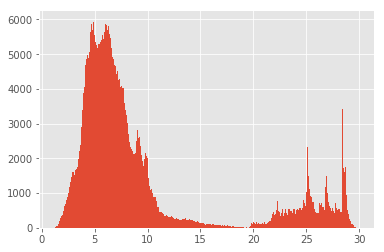

In [91]:
eesti_soil_red1_awc['SOL_SOC1'].hist(bins=600)
eesti_soil_red1_awc.drop(columns=['HYDGRP_rank','S_TXT_CLASS', 'P_SOIL_CLASS'], inplace=True)

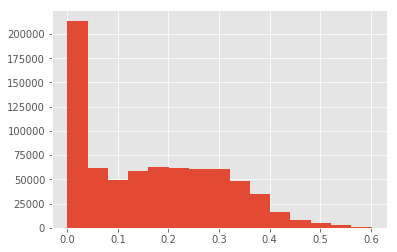

In [71]:
eesti_soil_red1_awc['USLE_K'].hist(bins=15)

C:\dev\conda3\envs\geopython-environment\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


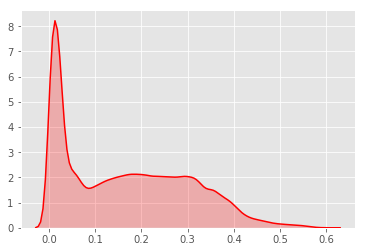

In [72]:
ax = sns.kdeplot(eesti_soil_red1_awc['USLE_K'].values, shade=True, color="r")

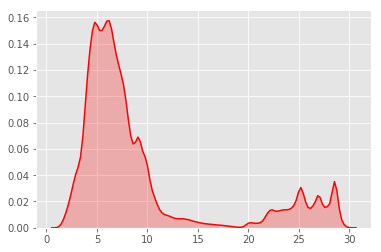

In [42]:
ax = sns.kdeplot(eesti_soil_red1_awc['SOL_SOC1'].values, shade=True, color="r")

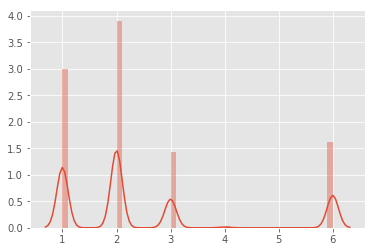

In [43]:
ax = sns.distplot(eesti_soil_red1_awc['P_SOIL_CLASS'].values)

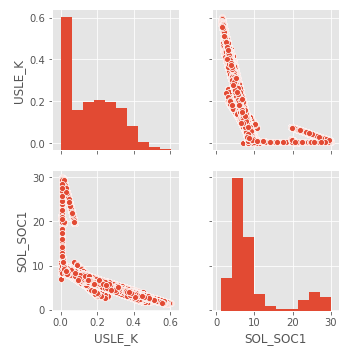

In [84]:
ax = sns.pairplot(eesti_soil_red1_awc[['USLE_K','SOL_SOC1']]);
# ax = sns.pairplot(eesti_soil_red1_awc[['USLE_K','SOL_SOC1','SOL_K1', 'P_SOIL_CLASS','HYDGRP_rank','S_TXT_CLASS']]);
# ax = sns.pairplot(eesti_soil_red1_awc[['USLE_K','SOL_SOC1','SOL_K1', 'P_SOIL_CLASS','HYDGRP_rank','S_TXT_CLASS']]);

In [28]:
def decide_A_1(x):
    if x == 'A':
        return 1
    if x == 'B':
        return 2
    if x == 'C':
        return 3
    if x == 'D':
        return 4
    else:
        return 5

eesti_soil_red1_awc['HYDGRP_rank'] = eesti_soil_red1_awc['HYDGRP'].apply(decide_A_1)
eesti_soil_red1_awc['HYDGRP'] = pd.Categorical(eesti_soil_red1_awc['HYDGRP'])

In [74]:
test1_df = eesti_soil_red1_awc[eesti_soil_red1_awc['SOL_SOC1'] >= 4]

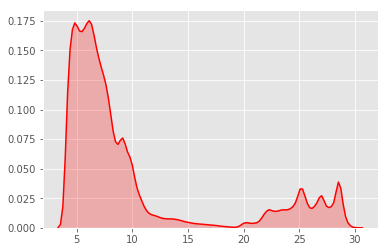

In [75]:
ax = sns.kdeplot(test1_df['SOL_SOC1'].values, shade=True, color="r")

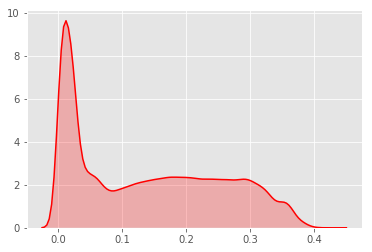

In [76]:
ax = sns.kdeplot(test1_df['USLE_K'].values, shade=True, color="r")

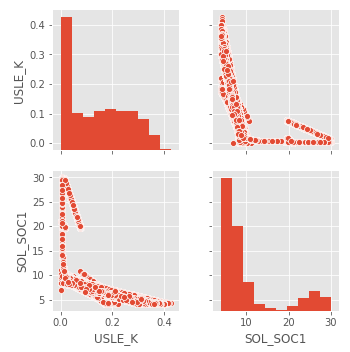

In [77]:
ax = sns.pairplot(test1_df[['USLE_K','SOL_SOC1']]);

In [61]:
eesti_soil_red1_awc['SOL_SOC1'].describe()

count    745442.000000
mean          9.371609
std           7.180558
min           1.200205
25%           5.046919
50%           6.685495
75%           9.381866
max          29.977685
Name: SOL_SOC1, dtype: float64

In [78]:
eesti_soil_red1_awc['USLE_K'].describe()

count    745442.000000
mean          0.165935
std           0.134774
min           0.000000
25%           0.026717
50%           0.153501
75%           0.274287
max           0.601539
Name: USLE_K, dtype: float64

In [81]:
test1_df2 = test1_df[ test1_df['USLE_K'] < 0.0001]

In [83]:
test1_df2['USLE_K'].describe()

count    55.000000
mean      0.000048
std       0.000030
min       0.000000
25%       0.000020
50%       0.000056
75%       0.000069
max       0.000098
Name: USLE_K, dtype: float64

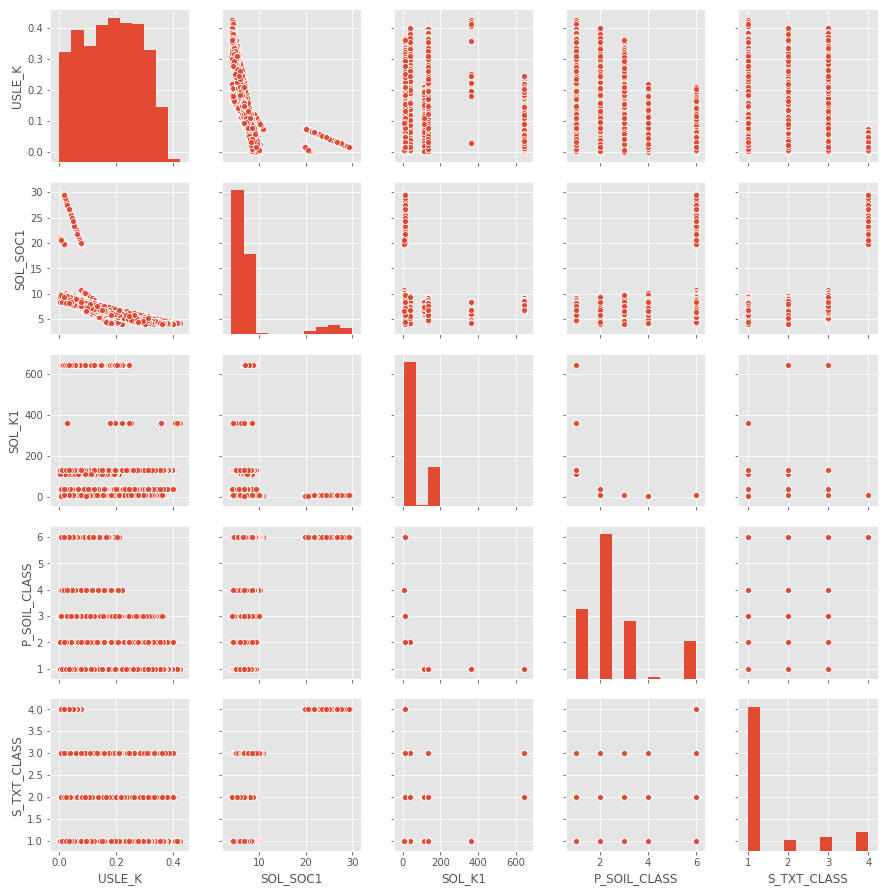

In [67]:
ax = sns.pairplot(test1_df2[['USLE_K','SOL_SOC1','SOL_K1', 'P_SOIL_CLASS','S_TXT_CLASS']]);

In [92]:
eesti_soil_red1_awc = eesti_soil_red1_awc[['orig_fid', 'upd_siffer', 'WRB_code', 'Boniteet', 'Varv', 'Loimis1',
       'loimis_rec', 'nlayers', 'SOL_ZMX', 'SOL_Z1', 'SOL_Z2', 'SOL_Z3',
       'SOL_Z4', 'EST_TXT1', 'LXTYPE1', 'EST_TXT2', 'LXTYPE2', 'EST_TXT3',
       'LXTYPE3', 'EST_TXT4', 'LXTYPE4', 'SOL_CLAY1', 'SOL_SILT1', 'SOL_SAND1',
       'SOL_ROCK1', 'SOL_CLAY2', 'SOL_SILT2', 'SOL_SAND2', 'SOL_ROCK2',
       'SOL_CLAY3', 'SOL_SILT3', 'SOL_SAND3', 'SOL_ROCK3', 'SOL_CLAY4',
       'SOL_SILT4', 'SOL_SAND4', 'SOL_ROCK4', 'SOL_SOC1', 'SOL_SOC2',
       'SOL_SOC3', 'SOL_SOC4', 'SOL_BD1', 'SOL_BD2', 'SOL_BD3', 'SOL_BD4',
       'SOL_K1', 'SOL_K2',  'SOL_K3', 'SOL_K4',
       'SOL_AWC1', 'SOL_AWC2', 'SOL_AWC3', 'SOL_AWC4','USLE_K','HYDGRP',
       'slp_mean', 'slp_median',
       'slp_stdev', 'twi_mean', 'twi_median', 'twi_stdev', 'ls_mean',
       'ls_median', 'ls_stdev', 'tri_mean', 'tri_median', 'tri_stdev',
       'area_drain', 'drain_pct', 'geometry']]

display(eesti_soil_red1_awc.sample(10))
display(eesti_soil_red1_awc.dtypes)

,orig_fid,upd_siffer,WRB_code,Boniteet,Varv,Loimis1,loimis_rec,nlayers,SOL_ZMX,SOL_Z1,...,twi_stdev,ls_mean,ls_median,ls_stdev,tri_mean,tri_median,tri_stdev,area_drain,drain_pct,geometry
697190,696792,M''',HS-sa,0,17,t₃60-100/l;ls₁,t₃60-100/l,2,1000,800,...,2.569084,0.209081,0.109198,0.256230,1.335270,0.962523,1.013501,69832.0,100.000,"POLYGON ((625875.9600000009 6437452.18, 625875..."
308793,308777,KIg,LV-gln.can,53,12,ls,ls,1,1000,1000,...,2.556270,0.044991,0.029327,0.026883,0.582039,0.631793,0.075782,NaN,NaN,"POLYGON ((615374.3500000015 6534326.309999999,..."
702493,702095,M''',HS-sa,40,17,t₂,t₂,1,1000,1000,...,3.028481,0.220038,0.207302,0.155320,1.491919,1.476766,0.308739,NaN,NaN,"POLYGON ((657390.200000003 6434398.920000002, ..."
8984,8799,AG,FL-gl,60,15,ls₂,ls₂,1,1000,1000,...,6.474233,0.529498,0.433209,0.393424,1.123475,1.174137,0.329867,NaN,NaN,"POLYGON ((661712.1000000015 6541610.48, 661718..."
94167,92016,E3k,RG-cap,27,18,vls,vls,1,1000,1000,...,0.442066,1.732745,1.771033,0.292381,5.031022,4.937824,0.489843,NaN,NaN,"POLYGON ((643760.6899999976 6402027.109999999,..."
593276,593265,LP,UM-rt.lv,46,6,sl/ls,sl/ls,1,1000,1000,...,1.645537,1.166924,1.133732,0.295905,4.776059,4.854374,0.491023,NaN,NaN,"POLYGON ((656165.3800000027 6409818.920000002,..."
653447,653436,M',HS-sa,0,17,None,t₃/l,1,1000,1000,...,1.345020,0.823367,0.823367,0.041119,2.789603,2.789603,0.118340,NaN,NaN,"POLYGON ((693787.5200000033 6395374.949999999,..."
174848,174848,Go,GL-mo.can,46,14,tsl40-70/+s,tsl40-70/+s,1,1000,1000,...,3.155064,0.021108,0.011050,0.038285,0.232333,0.205724,0.160625,677922.0,48.203,"POLYGON ((491139.2800000012 6529997.09, 491134..."
738295,738279,S''',HS-hm.dy,0,11,t₁20/t₃20-50/l,t₁20/t₃20-50/l,3,1000,200,...,1.468536,0.126975,0.107581,0.042883,0.499744,0.491480,0.052367,NaN,NaN,"POLYGON ((590061.0200000033 6598550.68, 590056..."
33964,33959,Dg,UM-gln-del.nv,43,19,k⁰₁sl,k⁰₁sl,1,1000,1000,...,1.108517,0.690832,0.614814,0.373520,3.444754,3.371759,0.767832,NaN,NaN,"POLYGON ((658151.9699999988 6393749.5, 658148...."


orig_fid        int64
upd_siffer     object
WRB_code       object
Boniteet        int64
Varv            int64
Loimis1        object
loimis_rec     object
nlayers         int64
SOL_ZMX         int64
SOL_Z1          int64
SOL_Z2        float64
SOL_Z3        float64
SOL_Z4        float64
EST_TXT1       object
LXTYPE1        object
EST_TXT2       object
LXTYPE2        object
EST_TXT3       object
LXTYPE3        object
EST_TXT4       object
LXTYPE4        object
SOL_CLAY1       int64
SOL_SILT1       int64
SOL_SAND1       int64
SOL_ROCK1       int64
SOL_CLAY2       int64
SOL_SILT2       int64
SOL_SAND2       int64
SOL_ROCK2       int64
SOL_CLAY3       int64
               ...   
SOL_SOC4      float64
SOL_BD1       float64
SOL_BD2       float64
SOL_BD3       float64
SOL_BD4       float64
SOL_K1        float64
SOL_K2        float64
SOL_K3        float64
SOL_K4        float64
SOL_AWC1      float64
SOL_AWC2      float64
SOL_AWC3      float64
SOL_AWC4      float64
USLE_K        float64
HYDGRP    

In [94]:
eesti_soil_red1_awc.to_file('eesti_soil_red1_texture_fix_geo_drain_soc_bd_ksat_awc_usle_hydgrp_final.shp',  driver='ESRI Shapefile', encoding='utf-8')
eesti_soil_red1_awc.to_file('eesti_soil_red1_texture_fix_geo_drain_soc_bd_ksat_awc_usle_hydgrp_final.gpkg', layer='estonia_soil_map', driver="GPKG", encoding='utf-8')

eesti_soil_red1_SWAT = eesti_soil_red1_awc[['orig_fid', 'upd_siffer', 'WRB_code', 'Boniteet', 'Varv', 'Loimis1',
       'loimis_rec', 'nlayers', 'SOL_ZMX', 'SOL_Z1', 'SOL_Z2', 'SOL_Z3',
       'SOL_Z4', 'EST_TXT1', 'LXTYPE1', 'EST_TXT2', 'LXTYPE2', 'EST_TXT3',
       'LXTYPE3', 'EST_TXT4', 'LXTYPE4', 'SOL_CLAY1', 'SOL_SILT1', 'SOL_SAND1',
       'SOL_ROCK1', 'SOL_CLAY2', 'SOL_SILT2', 'SOL_SAND2', 'SOL_ROCK2',
       'SOL_CLAY3', 'SOL_SILT3', 'SOL_SAND3', 'SOL_ROCK3', 'SOL_CLAY4',
       'SOL_SILT4', 'SOL_SAND4', 'SOL_ROCK4', 'SOL_SOC1', 'SOL_SOC2',
       'SOL_SOC3', 'SOL_SOC4', 'SOL_BD1', 'SOL_BD2', 'SOL_BD3', 'SOL_BD4',
       'SOL_K1', 'SOL_K2',  'SOL_K3', 'SOL_K4',
       'SOL_AWC1', 'SOL_AWC2', 'SOL_AWC3', 'SOL_AWC4','USLE_K','HYDGRP',
       'slp_mean', 'twi_mean', 'ls_mean', 'tri_mean',
       'area_drain', 'drain_pct', 'geometry']]

eesti_soil_red1_SWAT.to_file('eesti_soil_red1_texture_fix_geo_drain_soc_bd_ksat_awc_usle_hydgrp_final_swat.shp',  driver='ESRI Shapefile', encoding='utf-8')
eesti_soil_red1_SWAT.to_file('eesti_soil_red1_texture_fix_geo_drain_soc_bd_ksat_awc_usle_hydgrp_final_swat.gpkg', layer='estonia_soil_map_swat', driver="GPKG", encoding='utf-8')


C:\dev\conda3\envs\geopython-environment\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
C:\dev\conda3\envs\geopython-environment\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_estonia_soil_map_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_estonia_soil_map_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
C:\dev\conda3\envs\geopython-environment\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
C:\dev\conda3\envs\geopython-environment\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_estonia_soil_map_swat_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_estonia_soil_map_swat_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


In [88]:
display(fiona.Env())